In [1]:
import catboost
from catboost import * 
import numpy as np
import optuna 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
s = np.random.seed(42)
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

c:\workspace\telegram_bot\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_borders(column, data):
    sorted(column)
    q1, q3 = np.percentile(data[column], [25, 75])
    irq = q3 - q1
    lower = q1 - (1.5*irq)
    upper = q3 + (1.5*irq)
    return lower, upper

In [3]:
data = pd.read_csv('Obesity prediction.csv')


In [4]:
data

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [5]:
data['Obesity'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

In [7]:
data.isnull().sum()

Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64

In [8]:
categories_Obesity = [['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Insufficient_Weight', 'Obesity_Type_I', 'Obesity_Type_II',
       'Obesity_Type_III']]
categories_CAEC_CALC = ['no', 'Sometimes', 'Frequently', 'Always']
categories_MTRANS = [['Public_Transportation', 'Walking', 'Automobile', 'Motorbike','Bike']]
encoder_CAEC_CALC = OrdinalEncoder(categories = [categories_CAEC_CALC])
encoder_MTRANS = OrdinalEncoder(categories = categories_MTRANS)
encoder_Obesity = OrdinalEncoder(categories = categories_Obesity)
data['CAEC'] = encoder_CAEC_CALC.fit_transform(data[['CAEC']])
data['CALC'] = encoder_CAEC_CALC.fit_transform(data[['CALC']])
data['MTRANS'] = encoder_MTRANS.fit_transform(data[['MTRANS']])
data['Obesity'] = encoder_Obesity.fit_transform(data[['Obesity']])

In [9]:
data['Gender'] = np.where(data['Gender'] == 'Male', 1, 0)
data['family_history'] = np.where(data['family_history'] == 'yes', 1, 0)
data['SMOKE'] = np.where(data['SMOKE'] == 'yes', 1, 0)
data['SMOKE'] = np.where(data['SMOKE'] == 'yes', 1, 0)
data['FAVC'] = np.where(data['FAVC'] == 'yes', 1, 0)
data['SCC'] = np.where(data['SCC'] == 'yes', 1, 0)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   int32  
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   int32  
 5   FAVC            2111 non-null   int32  
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   float64
 9   SMOKE           2111 non-null   int32  
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   int32  
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   float64
 15  MTRANS          2111 non-null   float64
 16  Obesity         2111 non-null   float64
dtypes: float64(12), int32(5)
memory u

In [11]:
cat_data = data.select_dtypes(include=['object'])
cont_data = data.select_dtypes(include=['float64', 'int32'])

array([[<Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Height'}>,
        <Axes: title={'center': 'Weight'}>],
       [<Axes: title={'center': 'family_history'}>,
        <Axes: title={'center': 'FAVC'}>,
        <Axes: title={'center': 'FCVC'}>,
        <Axes: title={'center': 'NCP'}>],
       [<Axes: title={'center': 'CAEC'}>,
        <Axes: title={'center': 'SMOKE'}>,
        <Axes: title={'center': 'CH2O'}>,
        <Axes: title={'center': 'SCC'}>],
       [<Axes: title={'center': 'FAF'}>, <Axes: title={'center': 'TUE'}>,
        <Axes: title={'center': 'CALC'}>,
        <Axes: title={'center': 'MTRANS'}>],
       [<Axes: title={'center': 'Obesity'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

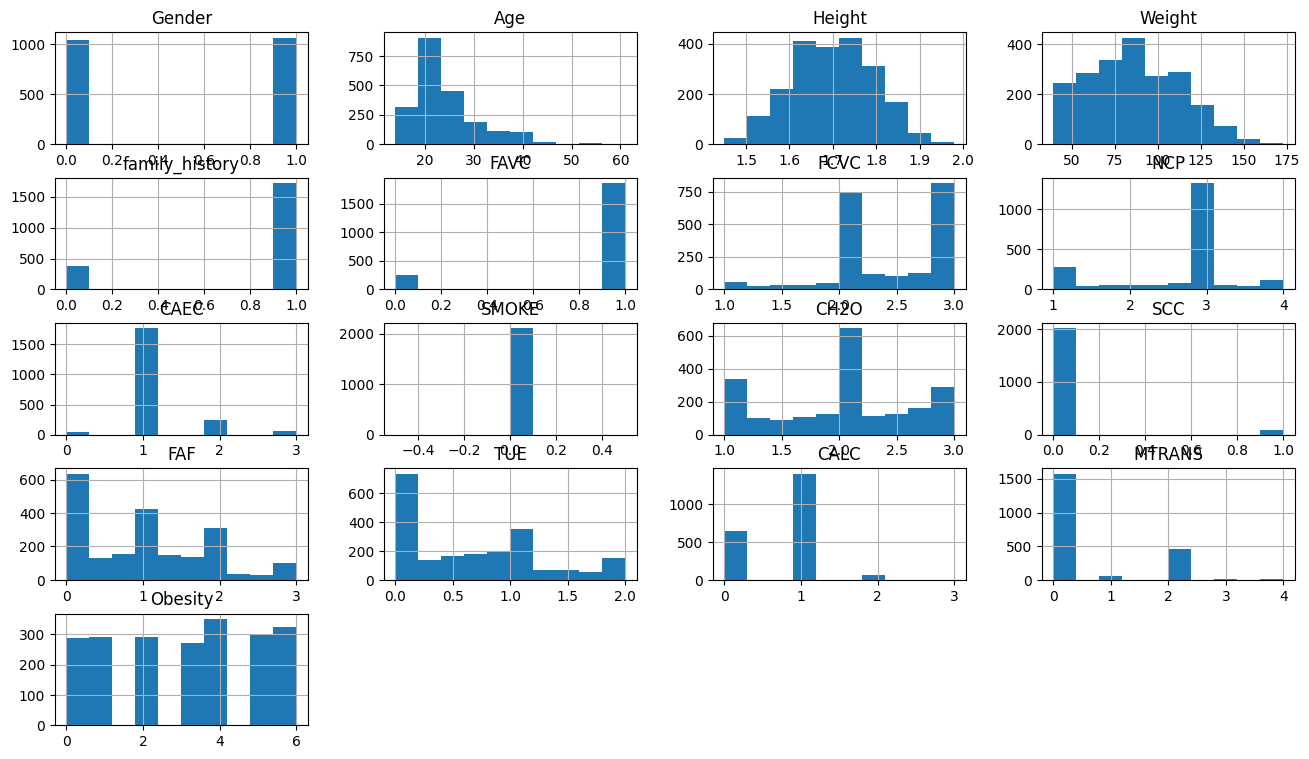

In [12]:
data.hist(figsize=(16,9))

<Axes: >

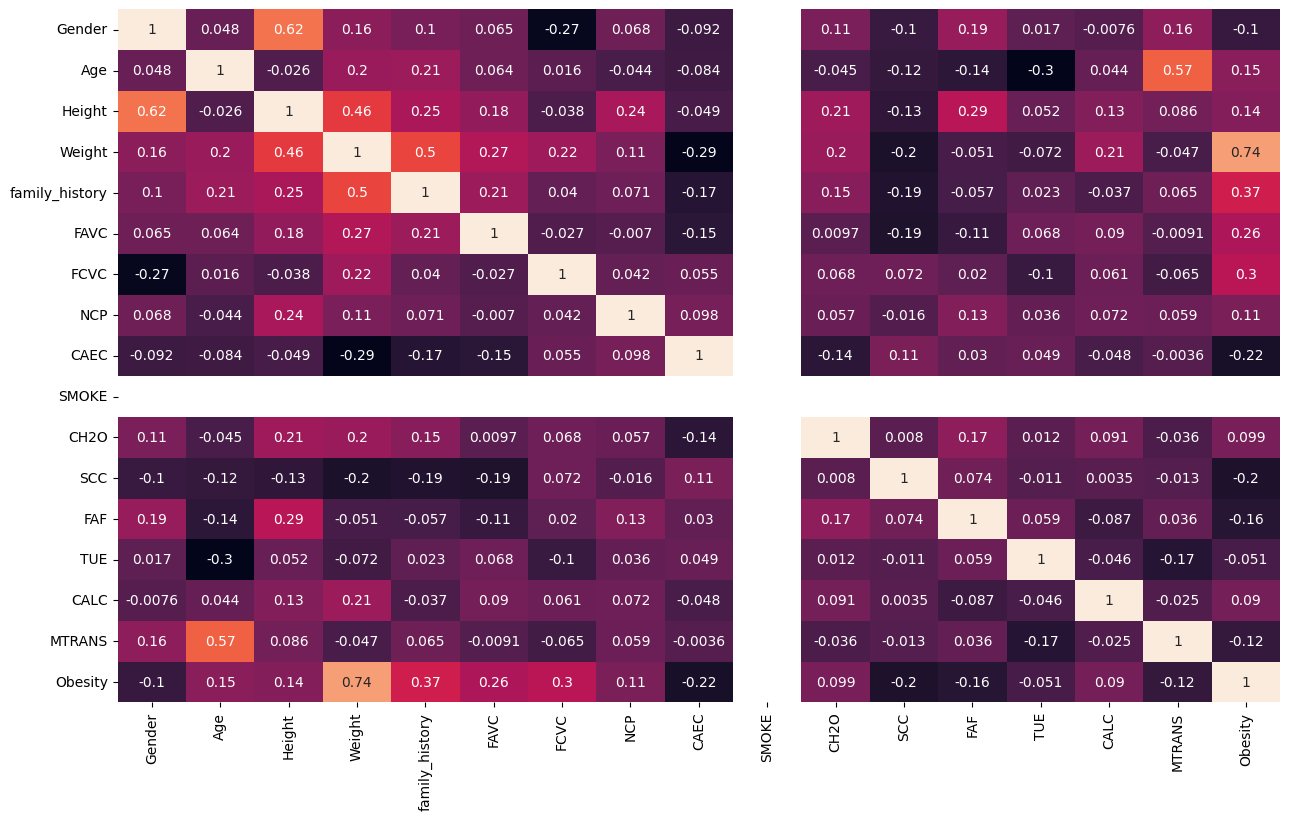

In [13]:
plt.figure(figsize=(15, 9))
corr_mat = cont_data.corr()
sns.heatmap(corr_mat, annot=True, cbar='')

<Axes: >

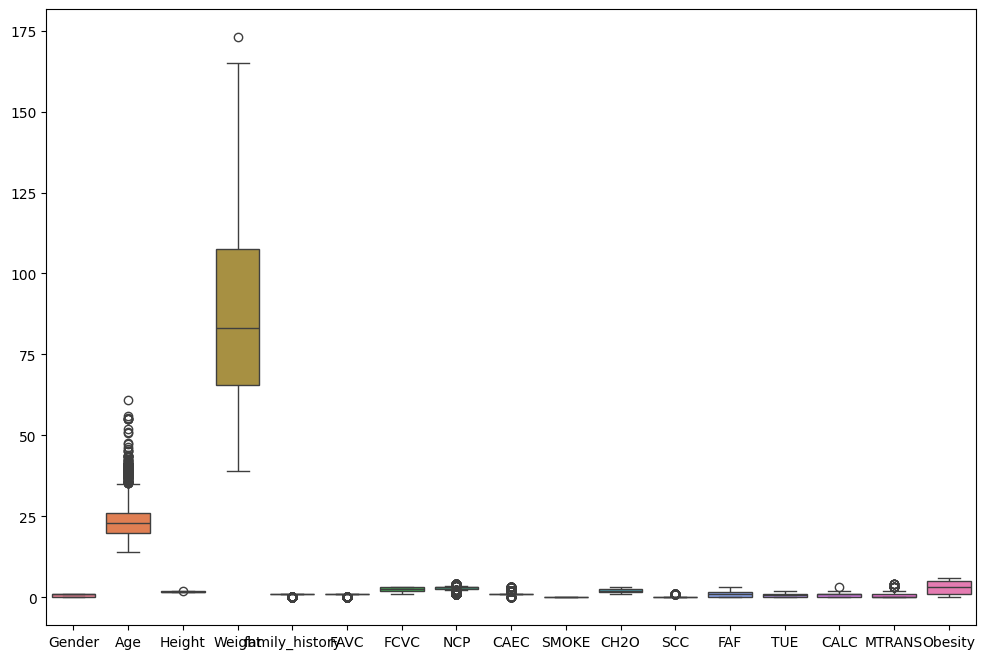

In [14]:
plt.figure(figsize=(12, 8))
sns.boxplot(cont_data)

In [15]:
lower_age, upper_age = get_borders('Age', cont_data)
lower_weight, upper_weight = get_borders('Weight', cont_data)
lower_ncp, upper_ncp = get_borders('NCP', cont_data)

In [16]:
cont_data.loc[cont_data['Age'] <= lower_age, 'Age'] = lower_age
cont_data.loc[cont_data['Age'] >= upper_age, 'Age'] = upper_age
cont_data.loc[cont_data['Weight'] <= lower_weight, 'Weight'] = lower_weight
cont_data.loc[cont_data['Weight'] >= upper_weight, 'Weight'] = upper_weight
cont_data.loc[cont_data['NCP'] <= lower_ncp, 'NCP'] = lower_ncp
cont_data.loc[cont_data['NCP'] >= upper_ncp, 'NCP'] = upper_ncp

<Axes: >

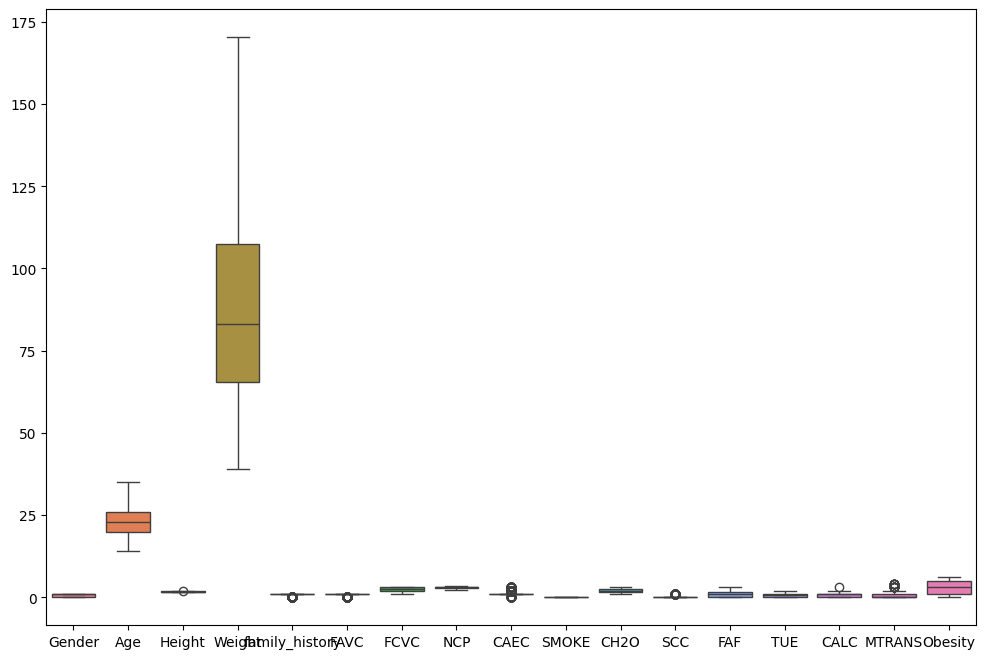

In [17]:
plt.figure(figsize=(12, 8))
sns.boxplot(cont_data)

In [19]:
data.to_csv('ready_data')

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,0,21.000000,1.620000,64.000000,1,0,2.0,3.0,1.0,0,2.000000,0,0.000000,1.000000,0.0,0.0,0.0
1,0,21.000000,1.520000,56.000000,1,0,3.0,3.0,1.0,0,3.000000,1,3.000000,0.000000,1.0,0.0,0.0
2,1,23.000000,1.800000,77.000000,1,0,2.0,3.0,1.0,0,2.000000,0,2.000000,1.000000,2.0,0.0,0.0
3,1,27.000000,1.800000,87.000000,0,0,3.0,3.0,1.0,0,2.000000,0,2.000000,0.000000,2.0,1.0,1.0
4,1,22.000000,1.780000,89.800000,0,0,2.0,1.0,1.0,0,2.000000,0,0.000000,0.000000,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1.710730,131.408528,1,1,3.0,3.0,1.0,0,1.728139,0,1.676269,0.906247,1.0,0.0,6.0
2107,0,21.982942,1.748584,133.742943,1,1,3.0,3.0,1.0,0,2.005130,0,1.341390,0.599270,1.0,0.0,6.0
2108,0,22.524036,1.752206,133.689352,1,1,3.0,3.0,1.0,0,2.054193,0,1.414209,0.646288,1.0,0.0,6.0
2109,0,24.361936,1.739450,133.346641,1,1,3.0,3.0,1.0,0,2.852339,0,1.139107,0.586035,1.0,0.0,6.0


In [18]:
y = data.Obesity
X = data.drop(['Obesity'], axis=1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.63, random_state=s)
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

In [20]:
X_train

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
255,1,19.000000,1.780000,81.000000,1,0,1.000000,3.000000,1.0,0,2.000000,0,3.000000,0.000000,0.0,4.0
882,1,33.100581,1.838791,87.857850,0,1,2.814453,2.608055,1.0,0,1.859160,0,2.000000,0.516084,0.0,2.0
389,0,16.000000,1.610000,65.000000,1,1,1.000000,1.000000,1.0,0,2.000000,0,0.000000,0.000000,0.0,0.0
1437,0,38.895069,1.549257,80.000000,1,1,2.736628,1.130751,1.0,0,1.385175,0,1.666965,0.000000,1.0,2.0
908,1,23.562135,1.717432,75.371244,1,1,2.000000,3.000000,1.0,0,2.000000,0,0.121585,1.967259,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,1,32.290160,1.754956,120.098812,1,1,2.967300,3.000000,1.0,0,2.530035,0,0.955317,1.339232,1.0,2.0
1095,1,23.000000,1.718981,81.669950,1,1,2.000000,1.729553,1.0,0,1.400247,0,0.887923,1.011983,1.0,0.0
1130,0,22.989846,1.650000,80.000000,1,1,2.000000,3.000000,1.0,0,2.000000,0,0.146919,2.000000,0.0,0.0
1294,0,23.000000,1.628168,84.497980,1,1,2.058687,2.962004,1.0,0,2.010596,0,0.851059,0.630866,0.0,0.0


In [5]:
a = [[2.]]

In [6]:
a[0][0]

2.0

In [ ]:
obesity_dict = {0 : 'Нормальный все', 1: 'избыточный вес I степени', 2 : 'избыточный вес II степени',
       3 : 'Ожирение I степени', 4 : 'Недостаточный вес', 5: 'Ожирение II степени',
       6 : 'Ожирение III степени'}

In [ ]:
obesity_dict[a[0][0]]

'Overweight_Level_II'

: 